In [148]:
import pandas as pd
import numpy as np
import random
import math
import gc
from collections import defaultdict
import matplotlib.pylab as plt
import networkx as nx
from copy import deepcopy

In [171]:
num_vertices = 100
edges = []
vertices = list(range(num_vertices))
# Initialize adjacency matrix
def init_adjacency_matrix(nodes, edges):
    adjacency_matrix = np.zeros((nodes,nodes),dtype = np.int)

    edge_probability = .0085 if nodes > 100 else 0.09


    edges_cnt = 0
    for i in range(nodes):
        for j in range(i):
            prob = random.random()
            if prob < edge_probability:
                adjacency_matrix[i,j] = 1
                edges.append((i,j))
                edges_cnt += 1

    return adjacency_matrix
adjacency_matrix = init_adjacency_matrix(num_vertices, edges)

In [172]:
G=nx.Graph()
G.add_nodes_from(list(range(num_vertices)))
G.add_edges_from(edges)

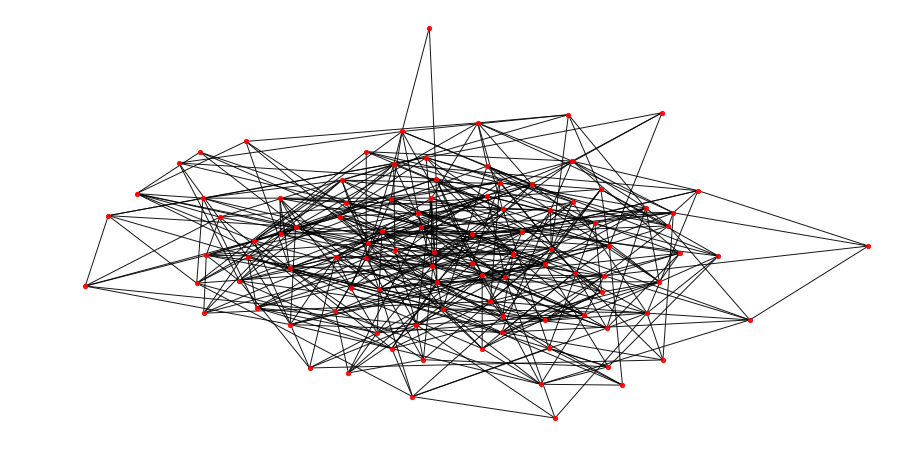

In [173]:
plt.figure(figsize=(12,6))
nx.draw(G,node_color='r', node_size=18, alpha=0.9)
plt.show() # display

In [174]:
# Initialize variables and constants
num_ants = 50
ant_dict = {ant: [random.choice(range(num_vertices)), 0] for ant in range(num_ants)} # ant: (curr_vertex, num_of_vertices_visited)
vertex_weights = {node:1 for node in range(num_vertices)}
tau_o = random.random() 
solution_set = []
q_o = 0.5
alpha = 0.1
psi = 0.3

In [175]:
# Helpers
def get_adjacent_vertices(vertex):
    vertices = []
    for vert,mark in enumerate(adjacency_matrix[vertex]):
        if mark> 0:
            vertices.append(vert)  
    return vertices

def get_arg_max_phermone():
    arg_max = []
    max_val = -1
    for vertex, value in vertex_values.items():
        # print(value, max_val)
        if value > max_val:
            max_val = value
            arg_max = [vertex]
            
        elif value == max_val:
            arg_max.append(vertex)
            
    return arg_max
def get_psi_k(vertex_i, vertex_j):
    return adjacency_matrix[vertex_i][vertex_j]

# Eta function
def get_eta_k(vertex):
    total_edges = sum([get_psi_k(vertex_i,vertex_j) for vertex_i in range(num_vertices) for vertex_j in range(num_vertices)])
    weight_vertex = vertex_weights[vertex]
    return total_edges/weight_vertex

In [176]:
vertex_phermones = {node:tau_o for node in range(num_vertices)}
vertex_values = {node: vertex_phermones[node]*get_eta_k(node)**alpha for node in range(num_vertices)}
print(ant_dict)

{0: [18, 0], 1: [70, 0], 2: [98, 0], 3: [82, 0], 4: [89, 0], 5: [79, 0], 6: [79, 0], 7: [23, 0], 8: [88, 0], 9: [87, 0], 10: [39, 0], 11: [87, 0], 12: [47, 0], 13: [82, 0], 14: [14, 0], 15: [67, 0], 16: [91, 0], 17: [91, 0], 18: [32, 0], 19: [96, 0], 20: [53, 0], 21: [68, 0], 22: [25, 0], 23: [45, 0], 24: [1, 0], 25: [67, 0], 26: [43, 0], 27: [72, 0], 28: [87, 0], 29: [89, 0], 30: [91, 0], 31: [91, 0], 32: [21, 0], 33: [64, 0], 34: [11, 0], 35: [11, 0], 36: [47, 0], 37: [45, 0], 38: [68, 0], 39: [14, 0], 40: [55, 0], 41: [32, 0], 42: [69, 0], 43: [76, 0], 44: [77, 0], 45: [58, 0], 46: [71, 0], 47: [14, 0], 48: [21, 0], 49: [97, 0]}


In [177]:
# Probability
def get_transition_probabilty(vertex_j,vertex_i=None, q_o=q_o, available_vertices = None):
    
    # vertex_j is current vertex and vertex_i is adjacent vertex
    q = random.random()
    
    if q <=q_o or not vertex_i:
        tau_j = vertex_phermones[vertex_j]
        eta_j_k = (get_eta_k(vertex_j))**alpha
        if not available_vertices:
            available_vertices = get_adjacent_vertices(vertex_j)
        denominator = sum([tau_j*get_eta_k(vert) for vert in available_vertices])
        return tau_j*eta_j_k / denominator
    
    arg_max = get_arg_max_phermone()
    
    if vertex_i in arg_max:
        return 1
    return 0
        

# Local update rule
def get_local_tau_j(vertex_j):
    return (1-psi)*vertex_phermones[vertex_j] + psi*tau_o
    
# Global update rule 
def get_delta_tau_j():
    total_weights = sum([vertex_weights[vertex_j] for vertex_j in solution_set])
    return 1/(total_weights) if total_weights > 0 else 0
    
def get_tau(vertex_i, local_phermone):
    delta_tau = get_delta_tau_j()
    tau = (1-get_transition_probabilty(vertex_i))*(local_phermone+vertex_phermones[vertex_i]) + delta_tau # We update based on local and current global phermones
    return tau

def update_eta_k(vertex, available_vertices = None):
    if not available_vertices:
        available_vertices = get_adjacent_vertices(vertex)
    # print("fnerfrewfw",sum([vertex_phermones[node]*get_eta_k(node)**alpha for node in available_vertices]))
    vertex_values[vertex] = sum([vertex_phermones[node]*get_eta_k(node)**alpha for node in available_vertices])
    return 
        
        
# Change this function
def all_ants_finished():
    all_ants_finished = False
    for (curr_vertex, num_vertices_visited) in ant_dict.values():
        all_ants_finished = all_ants_finished and (num_vertices_visited == num_vertices)
        
    if all_ants_finished:
        print("All ants finished")
    return all_ants_finished

In [178]:
def OptCover(start_index, connections, covered, total_sum):
    best_value = 0
    if start_index >= num_vertices:
        return
    if total_sum > best_value:
        return
    if covered == num_vertices:
        best_value = max(best_value, total_sum)
        return
    
    
def start_ACO(adjacency_matrix):
    local_phermone_dict = defaultdict(int)
    for i in range(2000):
        print(i)
        local_phermone_dict = defaultdict(int) # vertex: phermone used to sotre local phermone status
        for ant, (curr_vertex, num_vertices_visited) in ant_dict.items():
            if num_vertices_visited == num_vertices:
                print("done")
                break# Ant has not visited all vertices; ant is not finished
            random_prob =  random.random()
            available_vertices = get_adjacent_vertices(curr_vertex)
            # print(available_vertices)
            for adj_vertex in available_vertices:
                # print(adj_vertex)
                if adj_vertex in solution_set:
                    continue
                prob = get_transition_probabilty(curr_vertex, adj_vertex, available_vertices=available_vertices)
                # print(prob)
                # print(prob)
                if random_prob <= prob:
                    solution_set.append(adj_vertex)
                    ant_dict[ant] = [adj_vertex, num_vertices_visited+1]
                    
                    # Update adjacency matrix
                    adjacency_matrix[adj_vertex] = [0]*num_vertices
                    for row in range(num_vertices):
                        adjacency_matrix[row][adj_vertex] = 0
                        
                    # Update local phermone
                    local_phermone_val = get_local_tau_j(adj_vertex)
                    local_phermone_dict[adj_vertex] += local_phermone_val
                    
                    # Update eta 
                    update_eta_k(adj_vertex) 
                    break
                    
        for vertex, local_phermone in local_phermone_dict.items():
            
            # Not sure if this should be local or global
            vertex_phermones[vertex] =  get_tau(vertex, local_phermone) # This function uses local and global phermones for update
    return solution_set    
                    
# def ACO():
#     #Reset adjacency matrix and graph info
#     vertices_copy = deepcopy(vertices)
#     count = 0
#     #lines 19-38 need to be iterated
#     finished = all_ants_finished()
#     if not finished:
#         while count != 1:
#             for curr_vertex in vertices_copy:
#                 if not (curr_vertex in solution_set):
#                     # Add based on probaility
#                     solution_set.append(curr_vertex)
#                 else:
#                     if len(solution_set) >= len(vertices):
#                         break
#                     else:
#                         continue
#             get_adjacent_vertices(adjacency_matrix, curr_vertex)
#             count += 1
#     prob = get_transition_probabilty(adjacency_matrix, curr_vertex, q_o=q_o)
#     get_local_tau_j(curr_vertex)
#     get_delta_tau_j()
#     finished = all_ants_finished()
    

In [179]:
solutions = start_ACO(adjacency_matrix)

0


C:\Users\shriv\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [180]:
print(solutions)

[15, 5, 14, 44, 36, 12, 10, 68, 17, 9, 53, 16, 60, 4, 6, 28, 8, 11, 3, 42, 20, 31, 70, 45, 55, 50, 80, 2, 1, 29, 59, 38, 34, 13, 56, 35, 27]


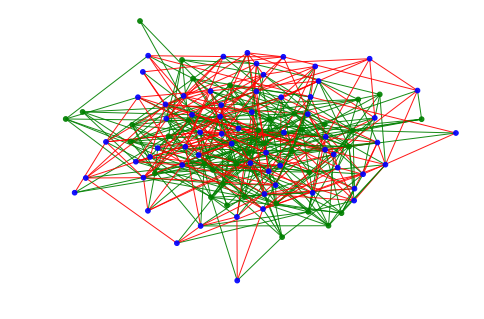

0.6425438596491229


In [181]:
color_map = []
for node in G:
    if node in solutions:
        color_map.append('green')
    else: 
        color_map.append('blue')      

edge_colours = []
for (u,v) in G.edges():
    if u in solutions or v in solutions:
        edge_colours.append("green")
    else:
        edge_colours.append("red")
        
nx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
plt.show()

edges_visited = 0
for col in edge_colours:
    if col == "green":
        edges_visited+=1
print(edges_visited/len(edge_colours))